# BMS_SOC_LSTM_2.0.1
- nicht mehr autoregressiv
- test funktioniert noch nicht

In [ ]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Falls du pytorch_forecasting nutzen möchtest:
from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM

torch.cuda.empty_cache()

###############################################################################
# 1) Laden der Daten, Reduktion auf 25%, zeitbasiertes Split in [Train, Val, Test]
###############################################################################
def load_cell_data(data_dir: Path):
    """Lade df.parquet aus dem Unterordner 'MGFarm_18650_C01'."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

# Anpassen an deinen Speicherort
data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)

# Wir gehen davon aus, dass wir mindestens eine Zelle haben
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

cell_name = cell_keys[0]  # z.B. 'C01'
df_full = cell_data[cell_name]

# Statt 10% nimmst du im Code 25% (wie im Kommentar ersichtlich)
sample_size = int(len(df_full) * 0.25)
df_small = df_full.head(sample_size).copy()  # vorderer Teil

print(f"Gesamtdaten: {len(df_full)}, wir nehmen 25% = {sample_size} Zeilen.")

# Zeit in datetime konvertieren (nur für Plot oder Zeit-spezifische Analysen)
df_small.loc[:, 'timestamp'] = pd.to_datetime(df_small['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])

# Zeitbasiertes Split: Train(40%), Val(40%), Test(20%) – gerne anpassen
len_small = len(df_small)
train_end = int(len_small * 0.4)
val_end   = int(len_small * 0.8)

df_train = df_small.iloc[:train_end]
df_val   = df_small.iloc[train_end:val_end]
df_test  = df_small.iloc[val_end:]

print(f"Train: {len(df_train)}  |  Val: {len(df_val)}  |  Test: {len(df_test)}")

###############################################################################
# 2) Skalierung von Voltage & Current (NICHT SOC, da SOC schon 0..1)
###############################################################################
scaler = StandardScaler()
features_to_scale = ['Voltage[V]', 'Current[A]']

# Fit nur auf Training
scaler.fit(df_train[features_to_scale])

# Transformation
df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features_to_scale] = scaler.transform(df_train_scaled[features_to_scale])
df_val_scaled[features_to_scale]   = scaler.transform(df_val_scaled[features_to_scale])
df_test_scaled[features_to_scale]  = scaler.transform(df_test_scaled[features_to_scale])

###############################################################################
# 3) Dataset-Klasse (standard seq2one, NICHT autoregressiv, KEIN SOC als Input)
###############################################################################
class SequenceDataset(Dataset):
    """
    Nicht-autoregressives Fenster:
      - X[t] = [Voltage, Current] für t..t+seq_len-1
      - y[t] = SOC an (t + seq_len)
    """
    def __init__(self, df, seq_len=60):
        self.seq_len = seq_len
        # Nur Voltage und Current als Features
        self.features = df[["Voltage[V]", "Current[A]"]].values
        # SOC als Label
        self.labels = df["SOC_ZHU"].values

    def __len__(self):
        return len(self.labels) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.features[idx : idx + self.seq_len]   # shape (seq_len, 2)
        y_val = self.labels[idx + self.seq_len]           # SOC-Wert
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Erstellen der Datasets
seq_length = 60
train_dataset = SequenceDataset(df_train_scaled, seq_len=seq_length)
val_dataset   = SequenceDataset(df_val_scaled,   seq_len=seq_length)
test_dataset  = SequenceDataset(df_test_scaled,  seq_len=seq_length)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=50000, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=50000, shuffle=False, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=50000, shuffle=False, drop_last=True)

###############################################################################
# 4) LSTM-Modell (pytorch_forecasting) oder nn.LSTM
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=2, batch_first=True):
        super().__init__()
        self.lstm = ForecastingLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, 2)
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)    # (batch_size,)

# Standard-Loss
criterion = nn.MSELoss()

# Modell + Optimizer
model = LSTMSOCModel(input_size=2, hidden_size=32, num_layers=2, batch_first=True)
optimizer = torch.optim.Adam(model.parameters(), lr=50e-3)

###############################################################################
# 5) Training mit Validation + Early Stopping + Gradient Accumulation
###############################################################################
# Vor Beginn des Trainings: Plot der gesamten Daten mit farbiger Markierung für Train/Val/Test
plt.figure(figsize=(12,6))
plt.plot(df_small['timestamp'], df_small['SOC_ZHU'], 'k-', label='SOC (alle Daten)')

# Bereiche farbig markieren:
plt.axvspan(df_train['timestamp'].iloc[0],
            df_train['timestamp'].iloc[-1],
            color='green', alpha=0.3, label='Training')
plt.axvspan(df_val['timestamp'].iloc[0],
            df_val['timestamp'].iloc[-1],
            color='orange', alpha=0.3, label='Validation')
plt.axvspan(df_test['timestamp'].iloc[0],
            df_test['timestamp'].iloc[-1],
            color='red', alpha=0.3, label='Test')

plt.xlabel('Time')
plt.ylabel('SOC (ZHU)')
plt.title('Datenaufteilung: Train, Val, Test')
plt.legend()
plt.tight_layout()
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 50
patience = 5  # Early Stopping

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

accumulation_steps = 10

for epoch in range(1, epochs+1):
    # --- TRAIN ---
    model.train()
    train_losses = []

    optimizer.zero_grad()

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Forward
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        
        # Für Gradient Accumulation
        loss = loss / accumulation_steps
        loss.backward()
        
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        train_losses.append(loss.item() * accumulation_steps)

    mean_train_loss = np.mean(train_losses)
    
    # --- VALIDATION ---
    model.eval()
    val_losses = []
    all_y_val = []
    all_y_pred = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred_val = model(x_val)
            v_loss = criterion(y_pred_val, y_val)
            val_losses.append(v_loss.item())
            # Sammle nur den ersten Batch zum Plot
            if not all_y_val:
                all_y_val.append(y_val.cpu().numpy())
                all_y_pred.append(y_pred_val.cpu().numpy())
    mean_val_loss = np.mean(val_losses)
    
    # Early Stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} because val_loss not improved.")
            break

    # Ausgabe der Loss-Werte
    print(f"Epoch {epoch:03d}/{epochs}, "
          f"Train MSE: {mean_train_loss:.6f}, "
          f"Val MSE: {mean_val_loss:.6f}, "
          f"NoImprove: {epochs_no_improve}")
    
    # --- VALIDATION PLOT (erster Batch) ---
    y_val_example = all_y_val[0].flatten()
    y_pred_example = all_y_pred[0].flatten()

    plt.figure(figsize=(10,4))
    plt.plot(y_val_example, label='Ground Truth')
    plt.plot(y_pred_example, label='Predicted')
    plt.title(f"Validation Predictions at Epoch {epoch}")
    plt.xlabel("Sample Index")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(1)  
    plt.close()

# Bestes Modell wiederherstellen
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nBest model reloaded with val_loss = {best_val_loss:.6f}")

###############################################################################
# 6) Standard (nicht-autoregressive) Vorhersage auf Testset
###############################################################################
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred_test = model(x_test)
        test_predictions.append(y_pred_test.cpu().numpy())
        test_targets.append(y_test.cpu().numpy())

test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Zeitachse anpassen
time_test = df_test['timestamp'].values[seq_length:seq_length + len(test_targets)]

###############################################################################
# 7) Plot: Ground Truth vs. Prediction (Test-Bereich)
###############################################################################
plt.figure(figsize=(12,5))
plt.plot(time_test, test_targets, label="Ground Truth SOC", linestyle='-')
plt.plot(time_test, test_predictions, label="Predicted SOC (LSTM)", linestyle='--')
plt.title(f"Nicht-autoregressive SOC-Vorhersage - Test (Zelle: {cell_name})")
plt.xlabel("Time")
plt.ylabel("SOC (ZHU)")
plt.legend()
plt.tight_layout()

# Modell + Plot speichern (optional)
models_dir = Path(__file__).parent / "models" if "__file__" in globals() else Path("models")
os.makedirs(models_dir, exist_ok=True)

plot_file = models_dir / "prediction_test.png"
plt.savefig(plot_file)
plt.show()
print(f"Test-Plot gespeichert unter: {plot_file}")

model_path = models_dir / "best_lstm_soc_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Bestes Modell gespeichert unter: {model_path}")


Loaded MGFarm_18650_C01
Gesamtdaten: 17167046, wir nehmen 25% = 4291761 Zeilen.
Train: 1716704  |  Val: 1716704  |  Test: 858353


/tmp/ipykernel_181612/74382658.py:158: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/florianr/anaconda3/envs/ml1/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


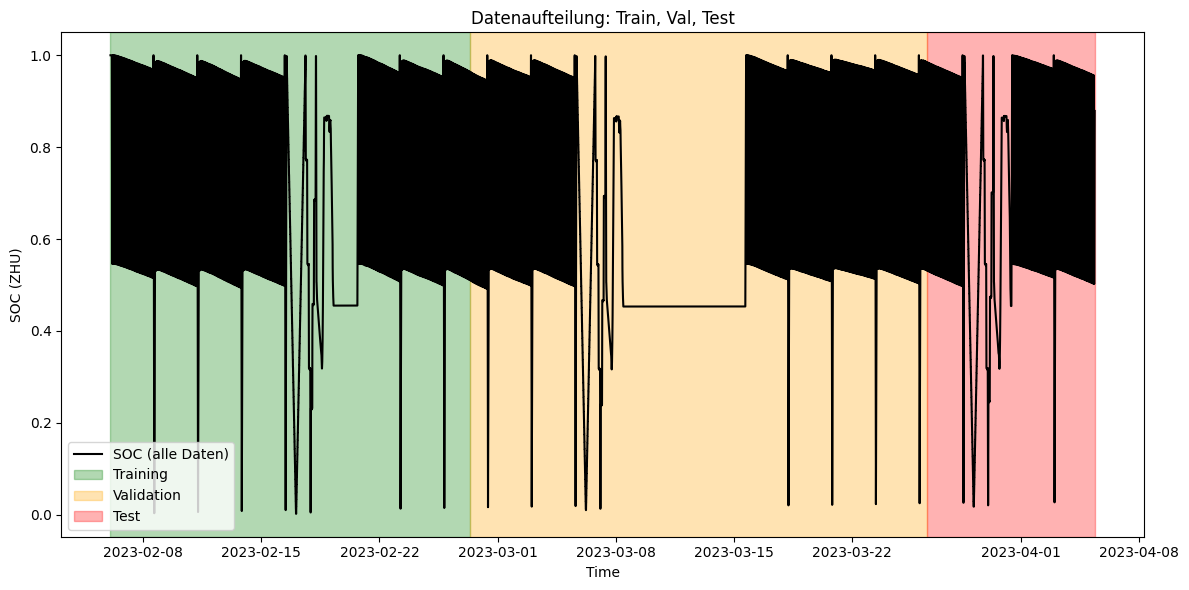

Epoch 001/50, Train MSE: 0.283201, Val MSE: 0.082015, NoImprove: 0


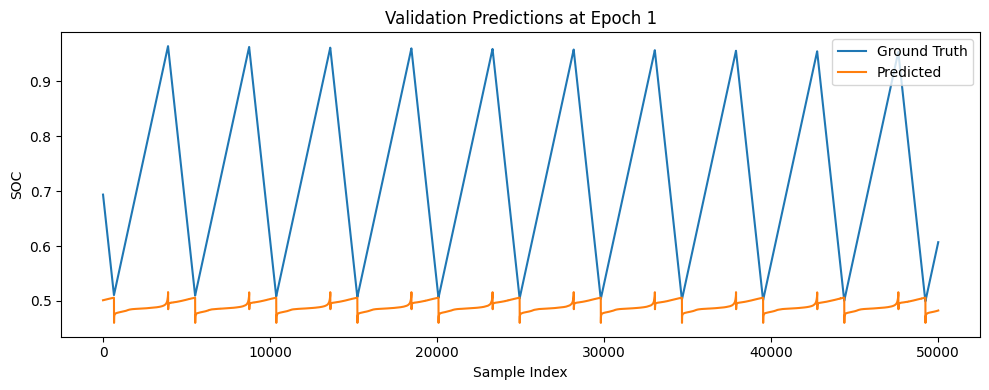

Epoch 002/50, Train MSE: 0.062669, Val MSE: 0.044728, NoImprove: 0


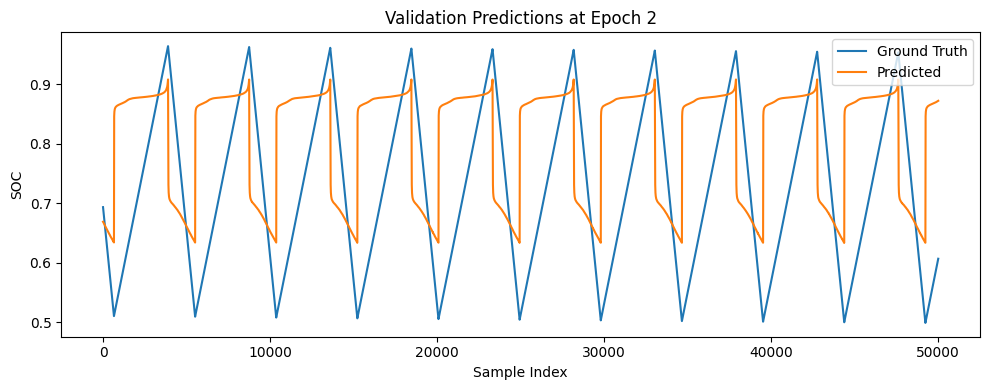

Epoch 003/50, Train MSE: 0.038754, Val MSE: 0.035871, NoImprove: 0


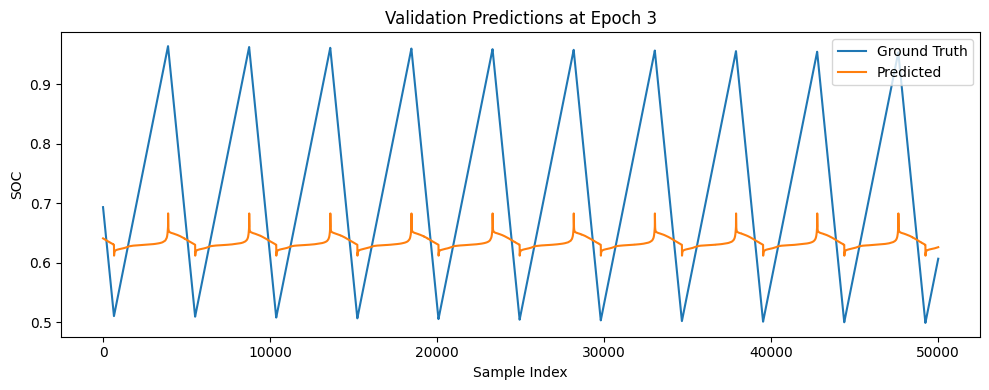

Epoch 004/50, Train MSE: 0.031908, Val MSE: 0.028506, NoImprove: 0


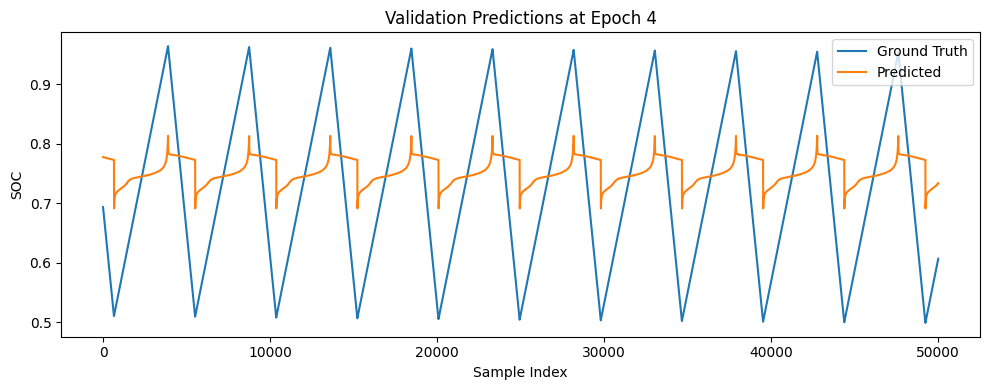

Epoch 005/50, Train MSE: 0.027886, Val MSE: 0.024034, NoImprove: 0


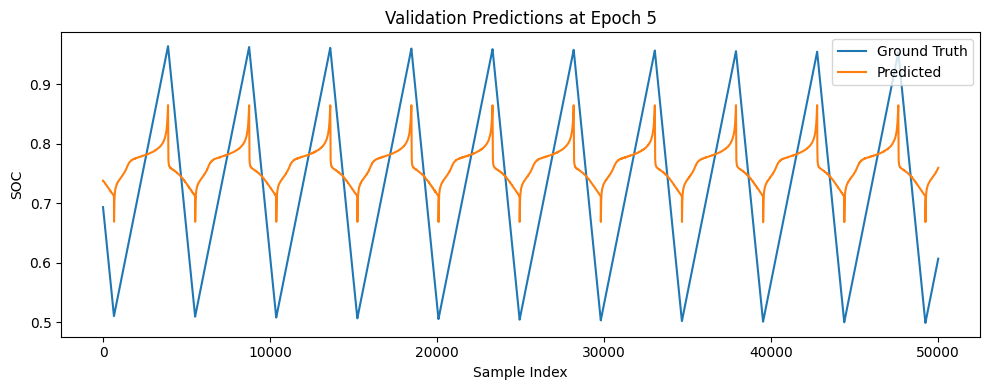

Epoch 006/50, Train MSE: 0.022194, Val MSE: 0.020238, NoImprove: 0


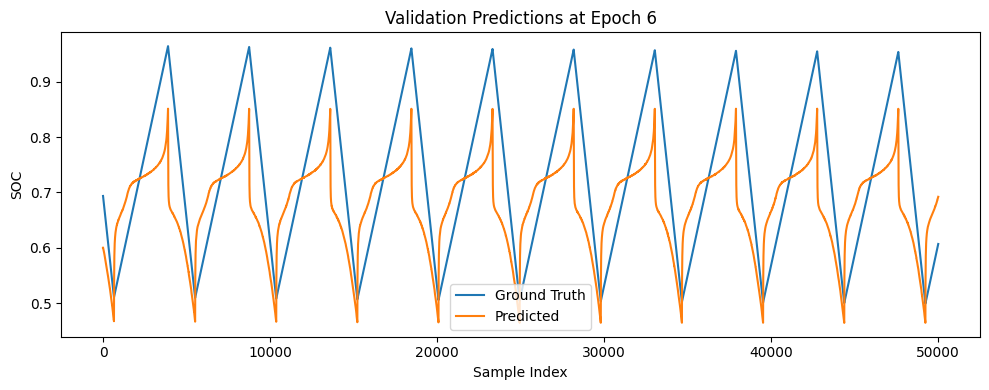

Epoch 007/50, Train MSE: 0.016506, Val MSE: 0.011995, NoImprove: 0


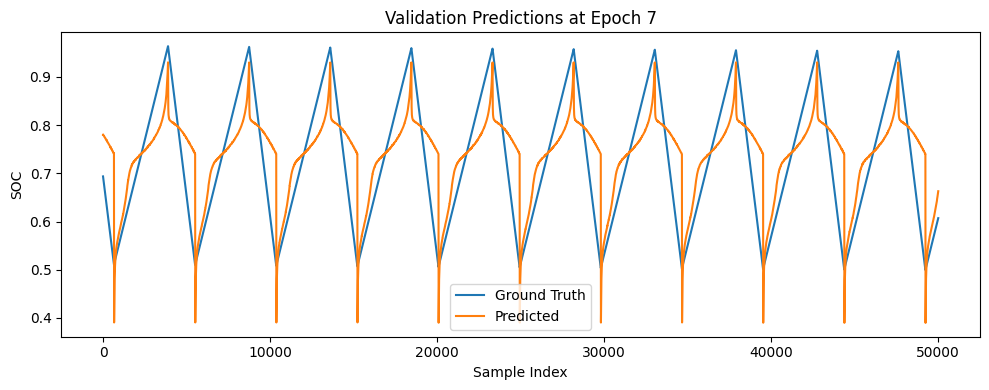

Epoch 008/50, Train MSE: 0.011486, Val MSE: 0.009641, NoImprove: 0


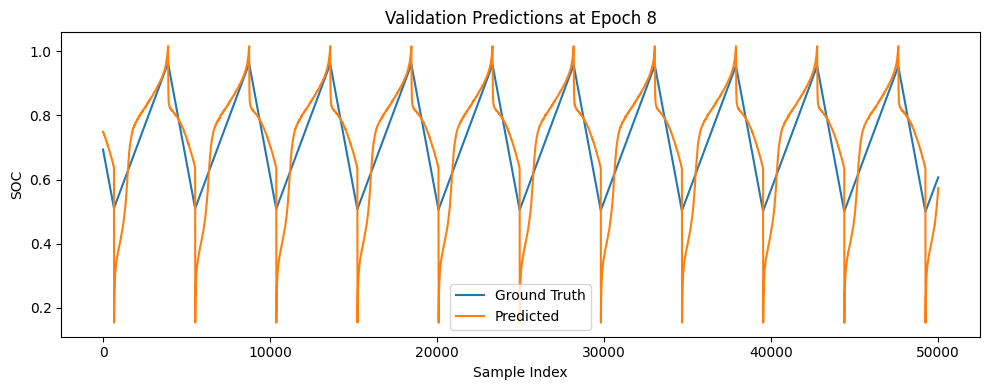

Epoch 009/50, Train MSE: 0.009259, Val MSE: 0.005599, NoImprove: 0


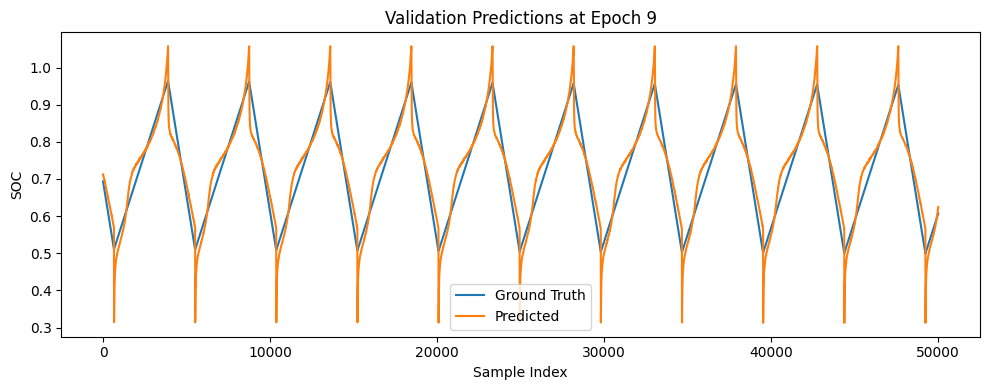

Epoch 010/50, Train MSE: 0.007205, Val MSE: 0.006812, NoImprove: 1


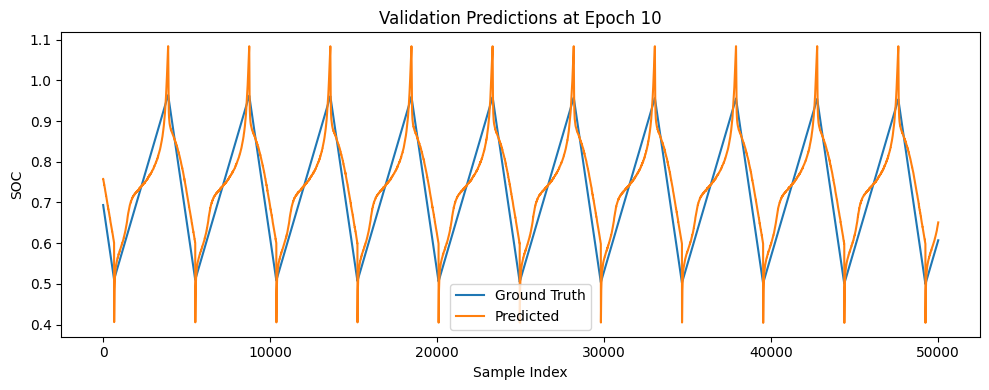

Epoch 011/50, Train MSE: 0.007156, Val MSE: 0.005675, NoImprove: 2


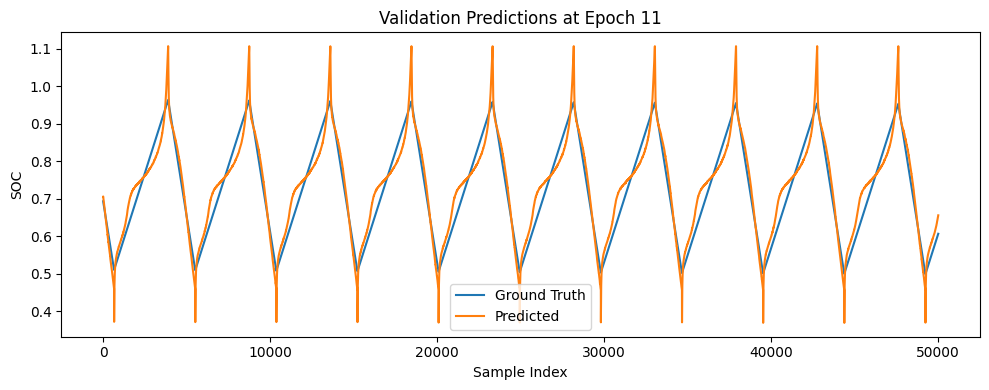

Epoch 012/50, Train MSE: 0.006545, Val MSE: 0.005391, NoImprove: 0


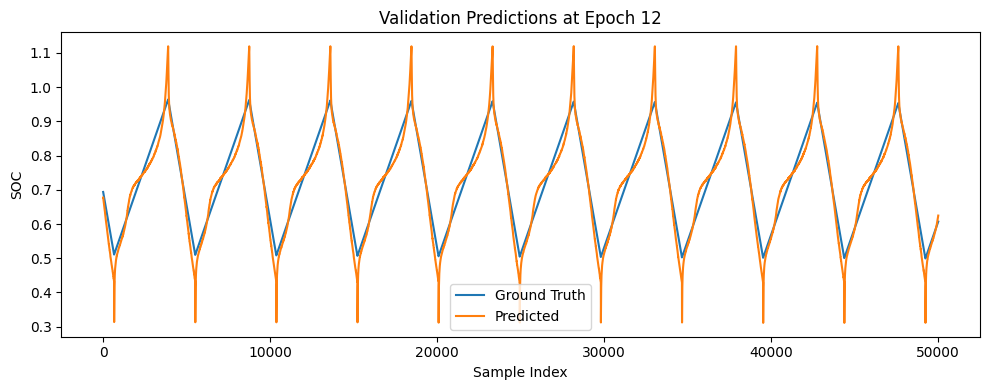

Epoch 013/50, Train MSE: 0.005999, Val MSE: 0.005309, NoImprove: 0


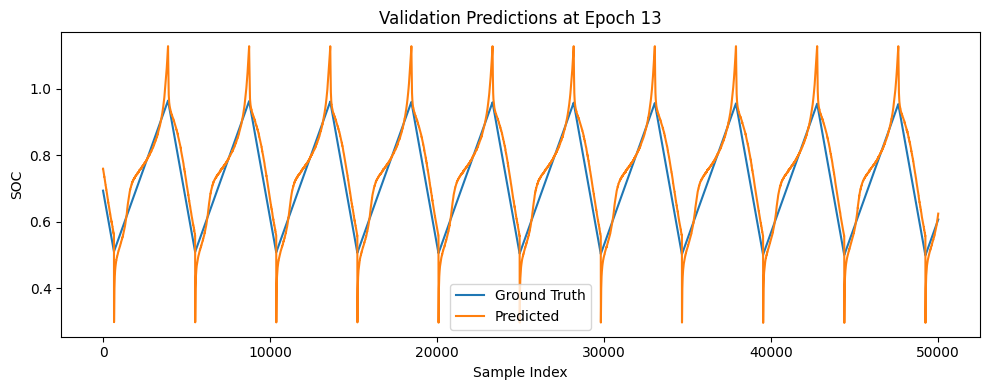

Epoch 014/50, Train MSE: 0.005844, Val MSE: 0.005080, NoImprove: 0


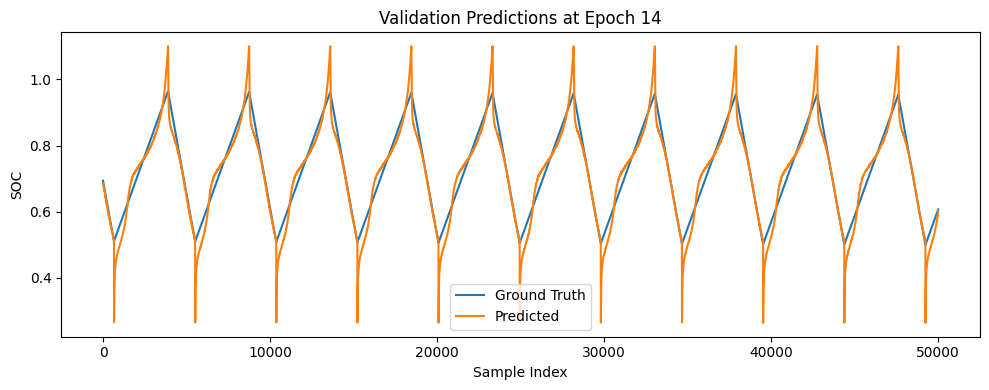

Epoch 015/50, Train MSE: 0.005768, Val MSE: 0.004943, NoImprove: 0


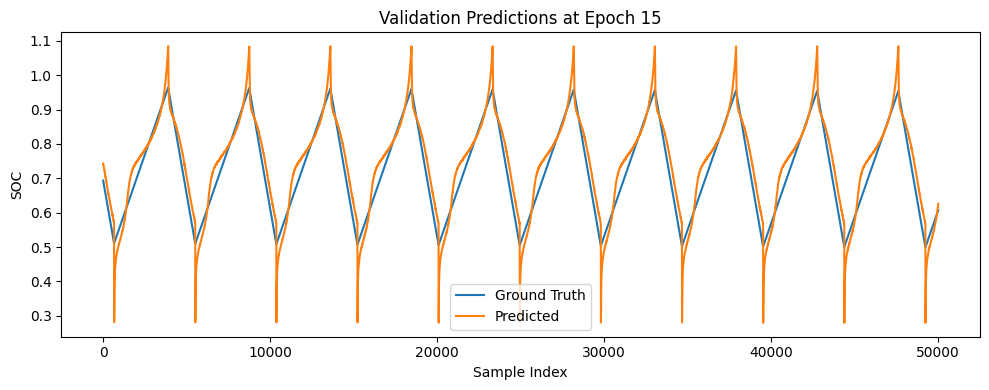

Epoch 016/50, Train MSE: 0.005558, Val MSE: 0.004674, NoImprove: 0


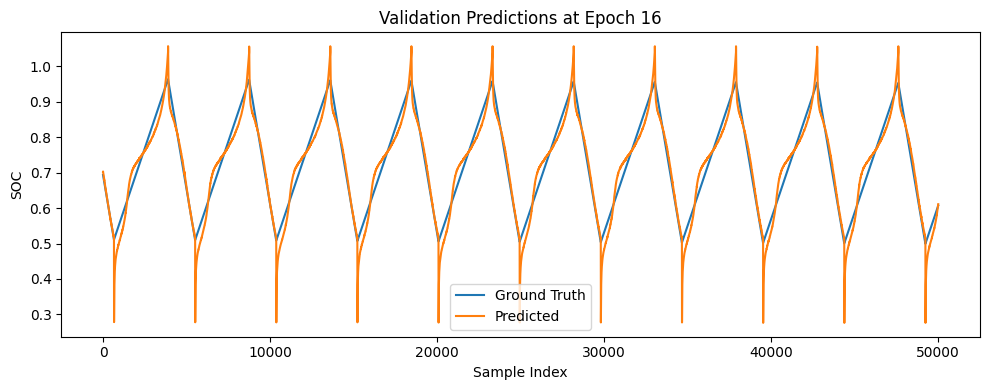

Epoch 017/50, Train MSE: 0.005353, Val MSE: 0.004614, NoImprove: 0


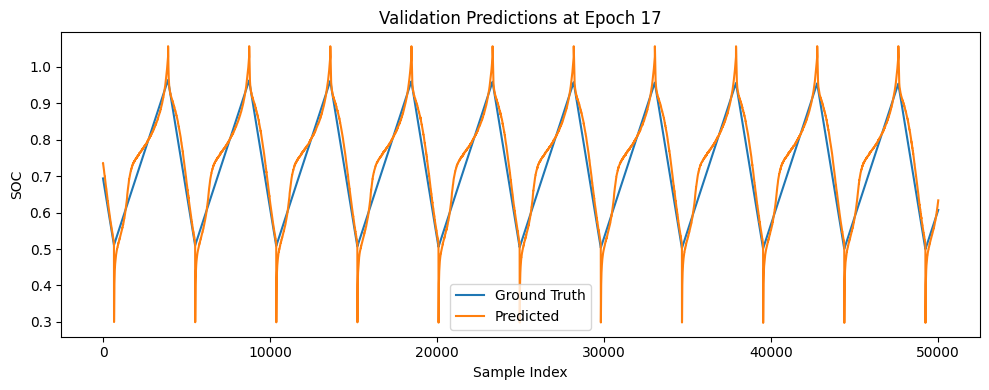

Epoch 018/50, Train MSE: 0.005293, Val MSE: 0.004566, NoImprove: 0


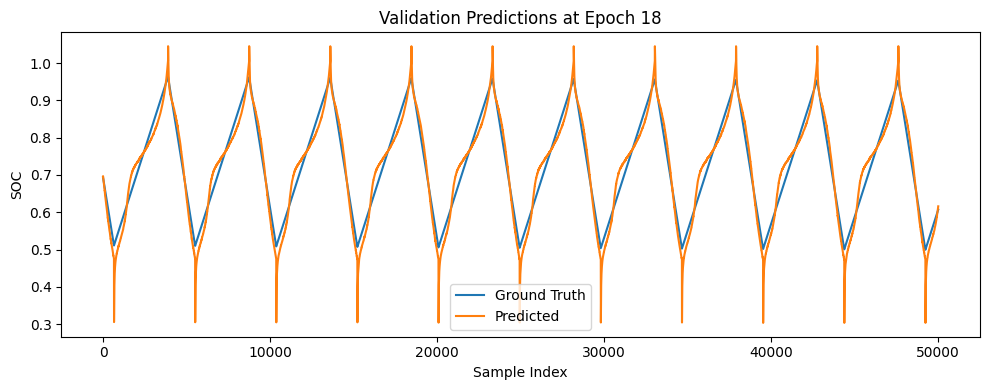

Epoch 019/50, Train MSE: 0.005230, Val MSE: 0.004486, NoImprove: 0


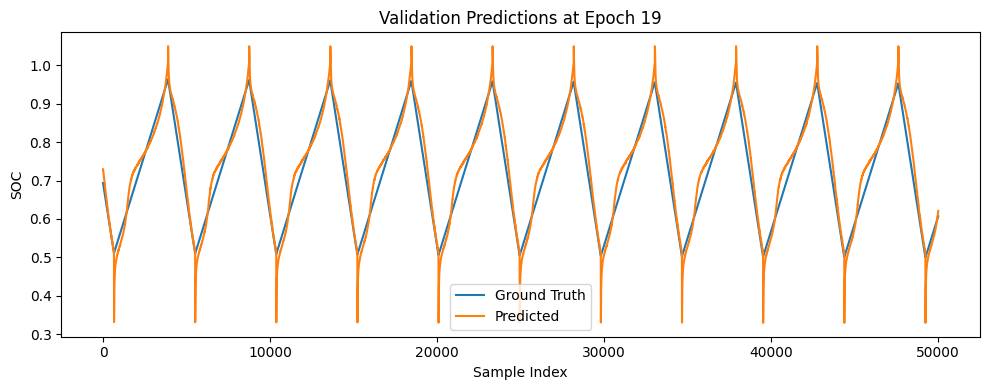

Epoch 020/50, Train MSE: 0.005081, Val MSE: 0.004265, NoImprove: 0


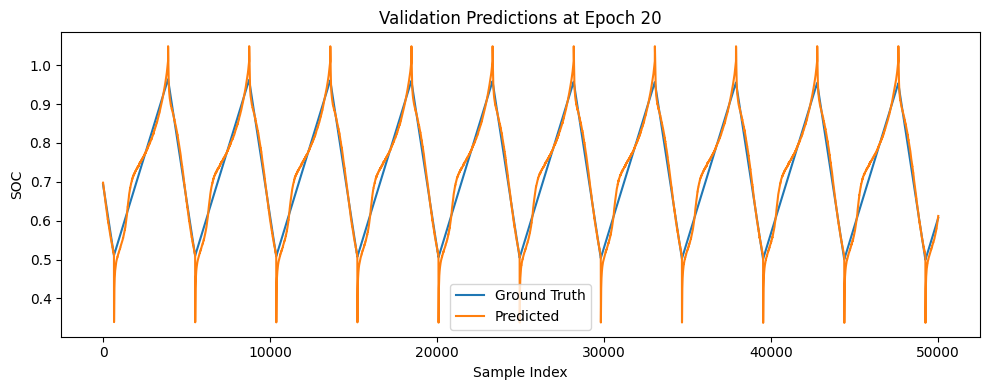

Epoch 021/50, Train MSE: 0.004978, Val MSE: 0.004247, NoImprove: 0


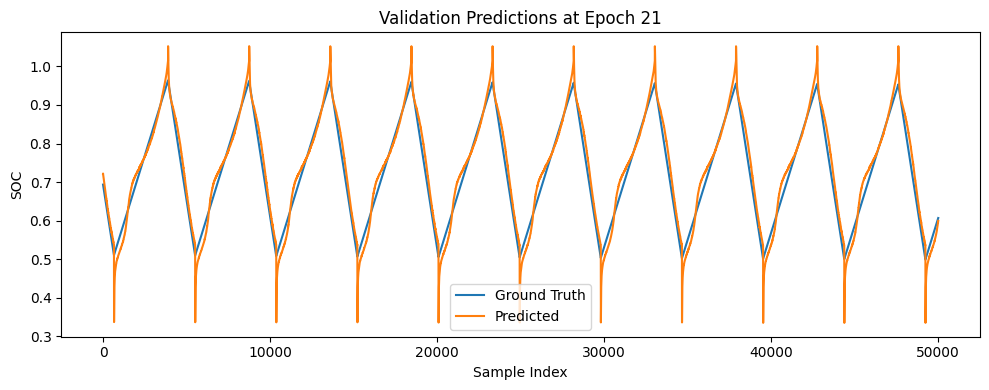

Epoch 022/50, Train MSE: 0.004918, Val MSE: 0.004113, NoImprove: 0


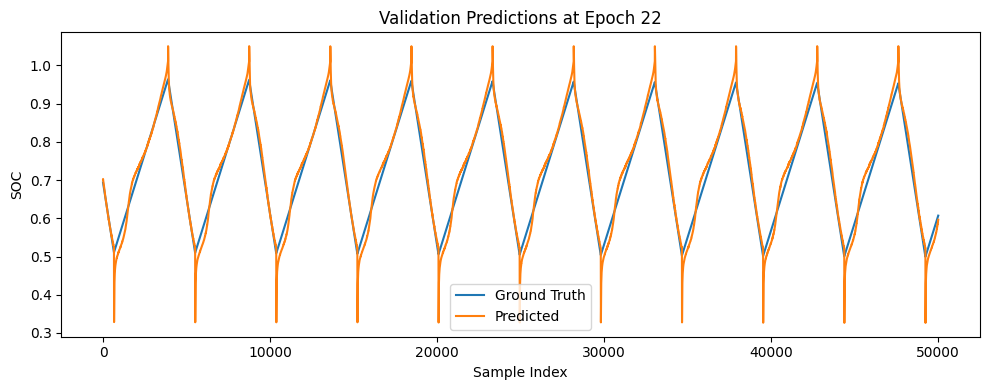

Epoch 023/50, Train MSE: 0.004844, Val MSE: 0.004082, NoImprove: 0


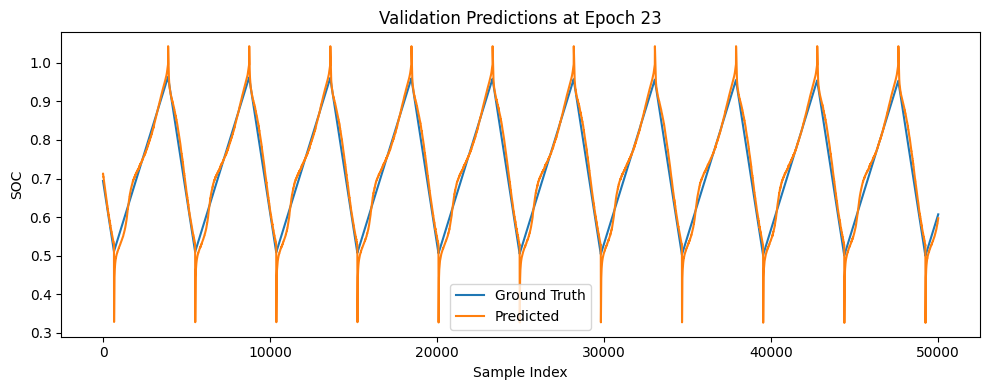

Epoch 024/50, Train MSE: 0.004763, Val MSE: 0.004008, NoImprove: 0


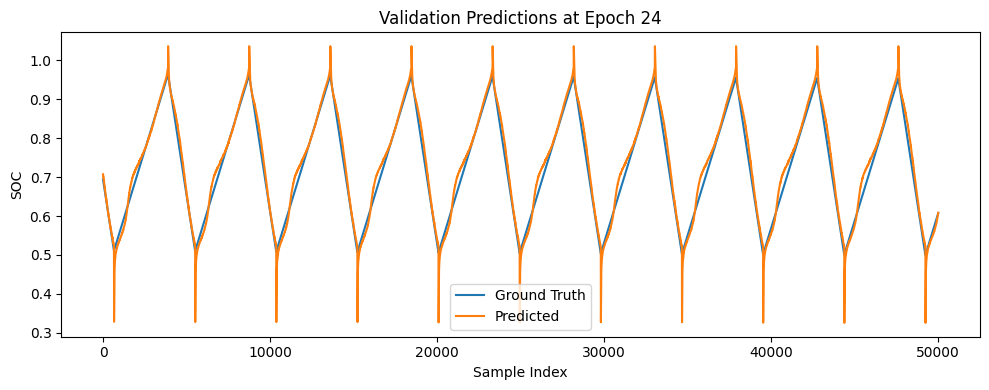

Epoch 025/50, Train MSE: 0.004728, Val MSE: 0.004007, NoImprove: 0


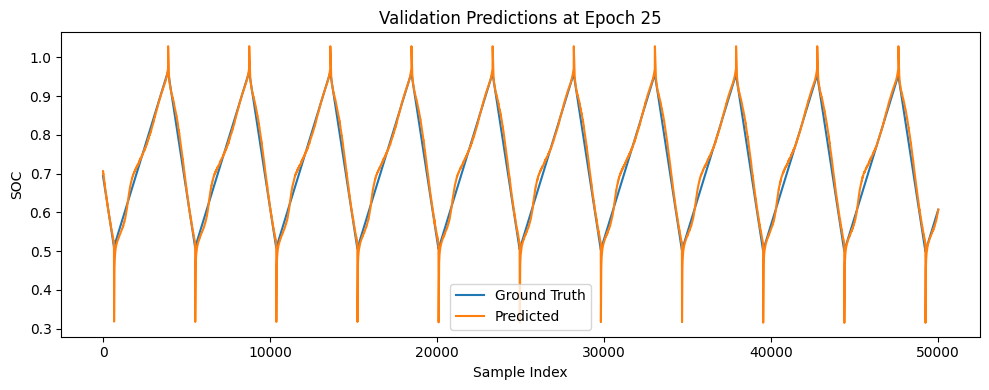

Epoch 026/50, Train MSE: 0.004697, Val MSE: 0.003958, NoImprove: 0


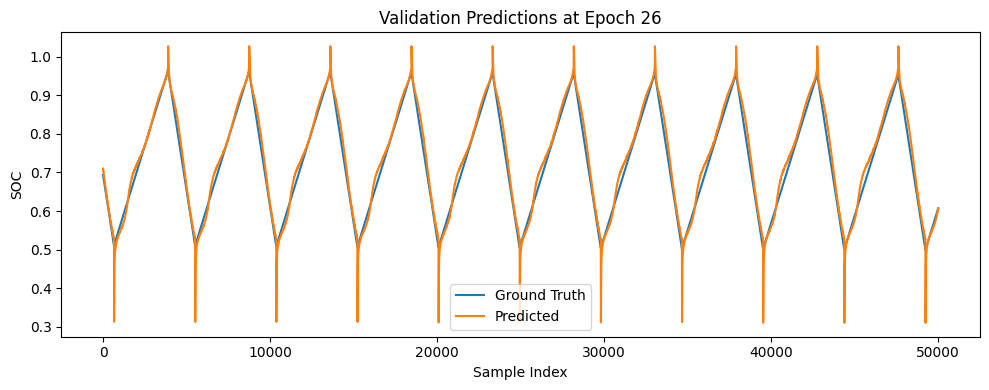

Epoch 027/50, Train MSE: 0.004667, Val MSE: 0.003947, NoImprove: 0


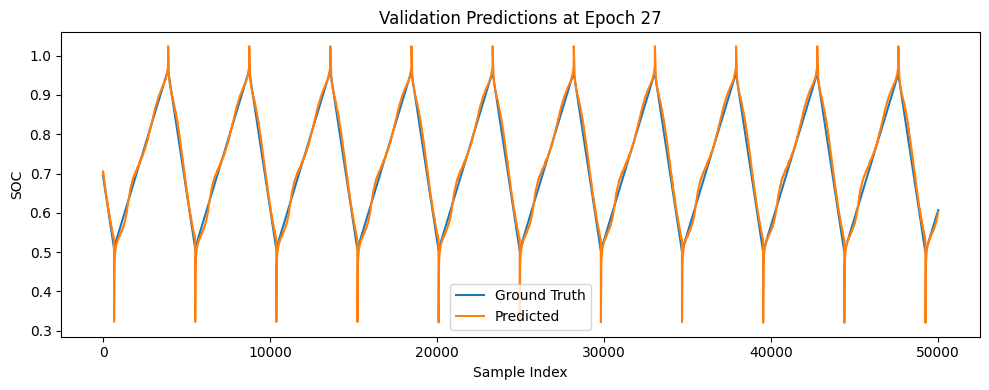

Epoch 028/50, Train MSE: 0.004663, Val MSE: 0.003937, NoImprove: 0


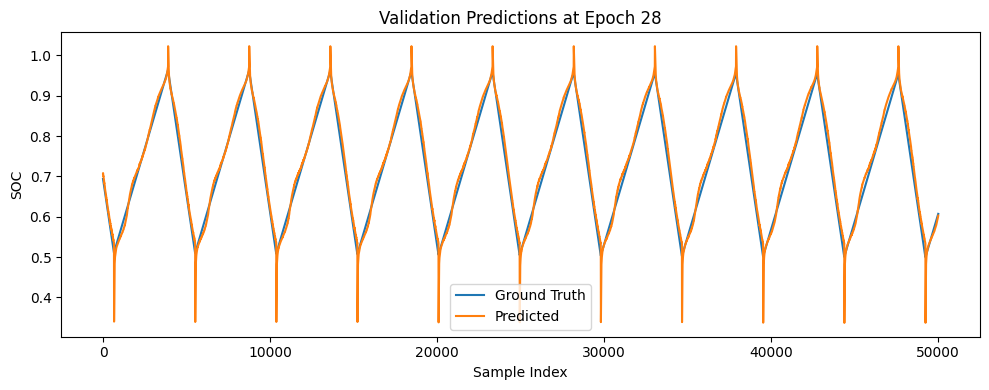

Epoch 029/50, Train MSE: 0.004647, Val MSE: 0.003939, NoImprove: 1


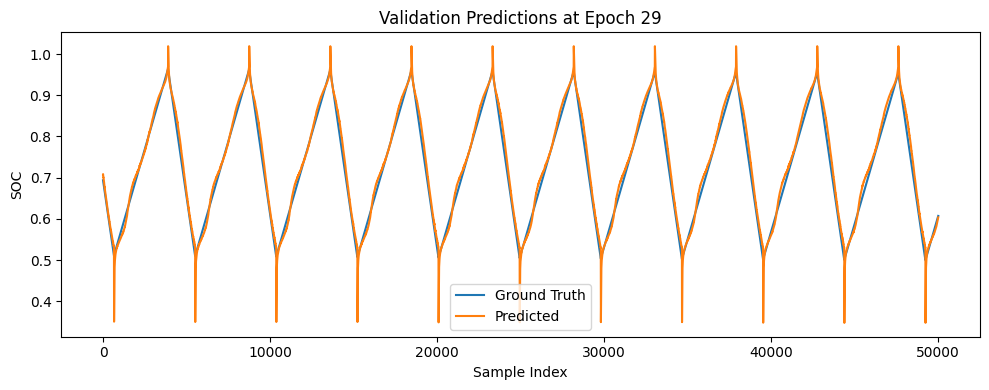

Epoch 030/50, Train MSE: 0.004632, Val MSE: 0.003924, NoImprove: 0


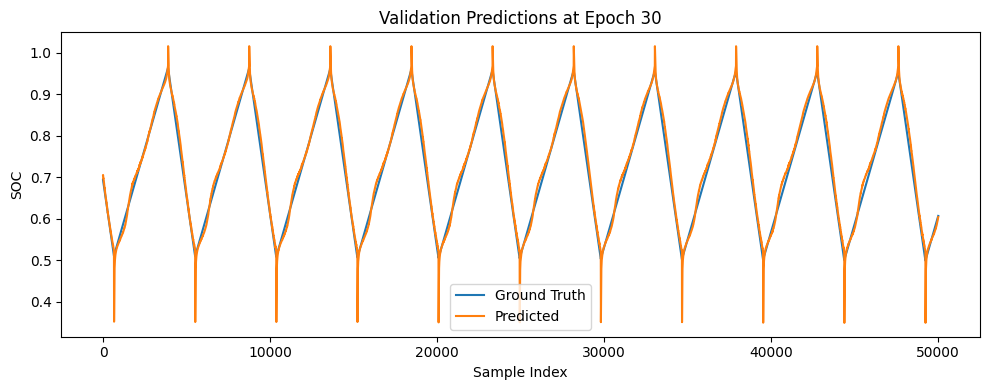

Epoch 031/50, Train MSE: 0.004616, Val MSE: 0.003922, NoImprove: 0


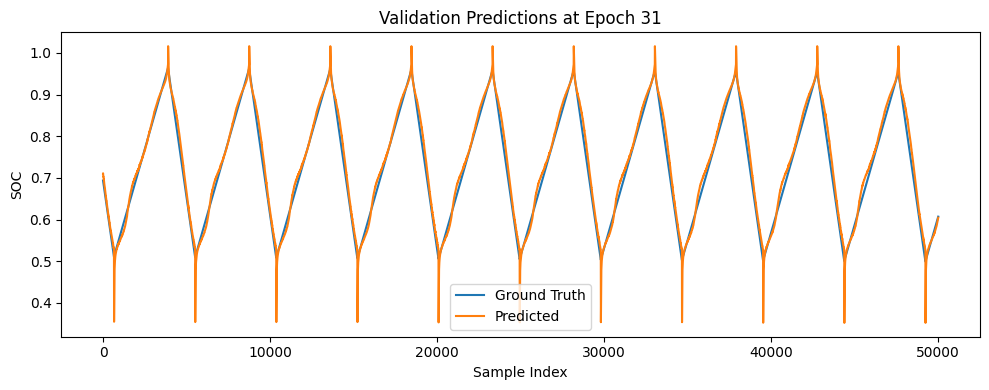

Epoch 032/50, Train MSE: 0.004605, Val MSE: 0.003894, NoImprove: 0


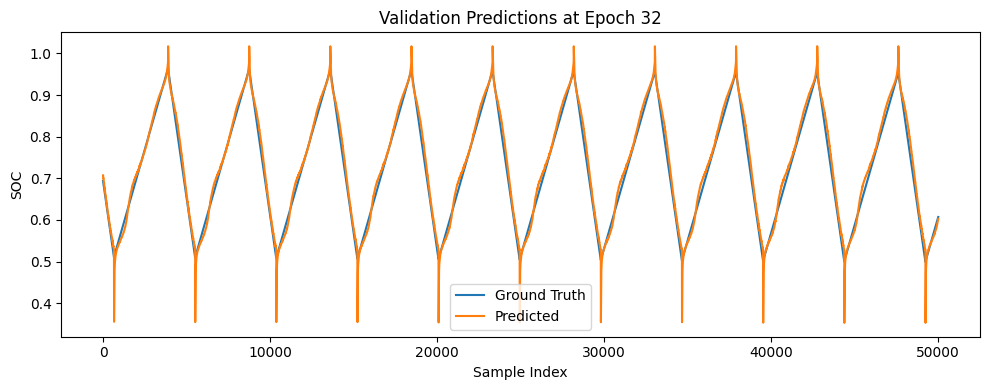

Epoch 033/50, Train MSE: 0.004591, Val MSE: 0.003892, NoImprove: 0


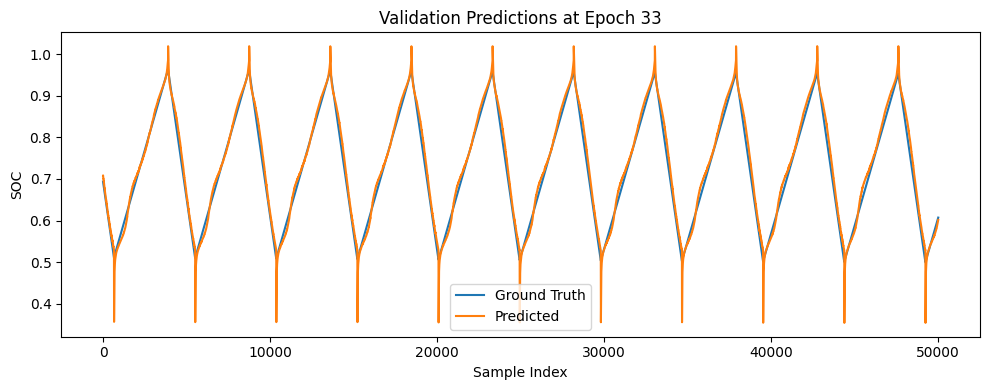

Epoch 034/50, Train MSE: 0.004578, Val MSE: 0.003878, NoImprove: 0


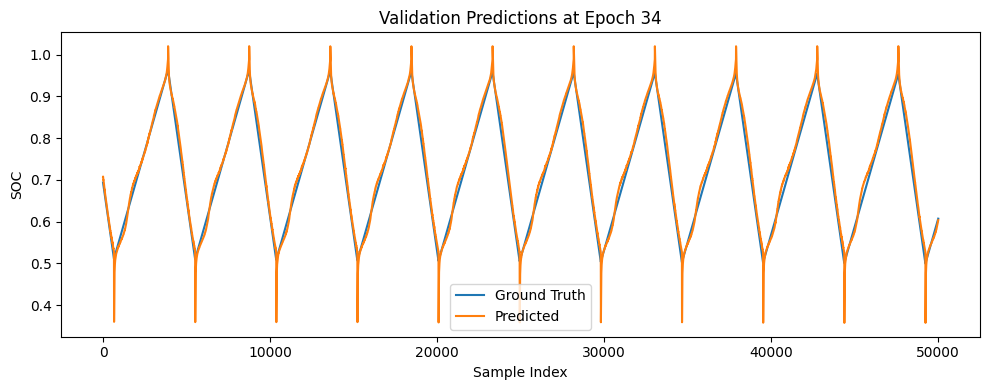

Epoch 035/50, Train MSE: 0.004565, Val MSE: 0.003880, NoImprove: 1


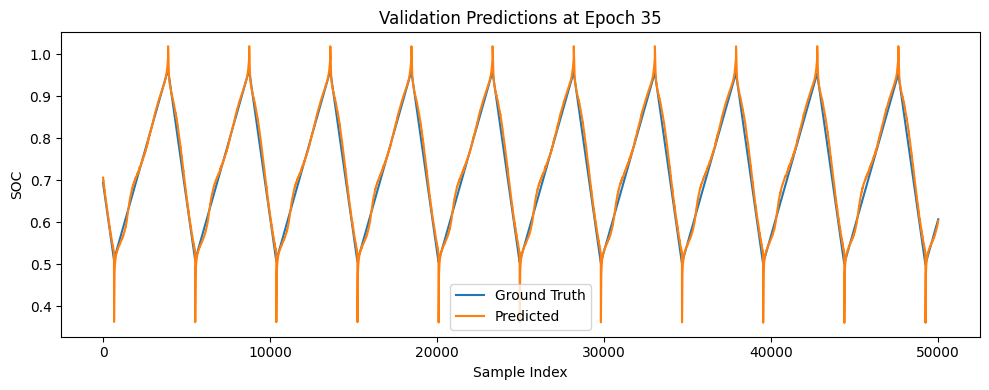

Epoch 036/50, Train MSE: 0.004555, Val MSE: 0.003863, NoImprove: 0


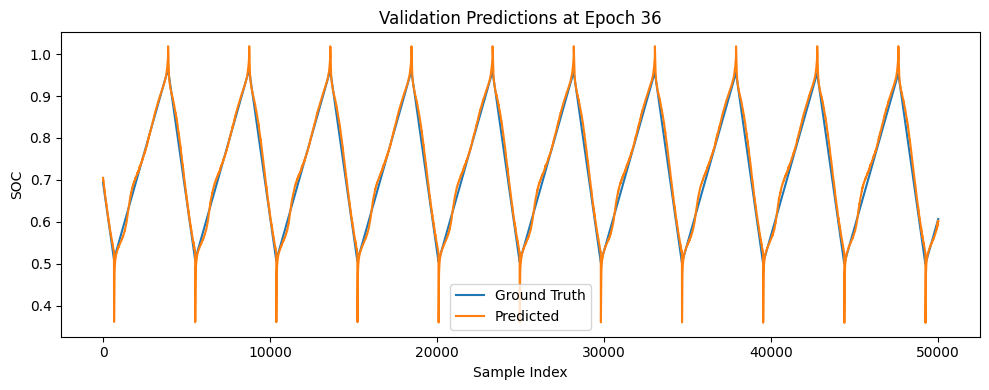

Epoch 037/50, Train MSE: 0.004546, Val MSE: 0.003856, NoImprove: 0


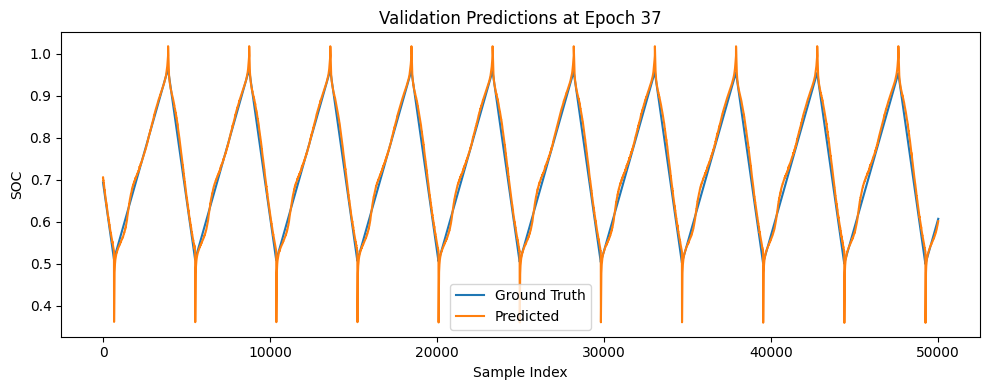

Epoch 038/50, Train MSE: 0.004533, Val MSE: 0.003846, NoImprove: 0


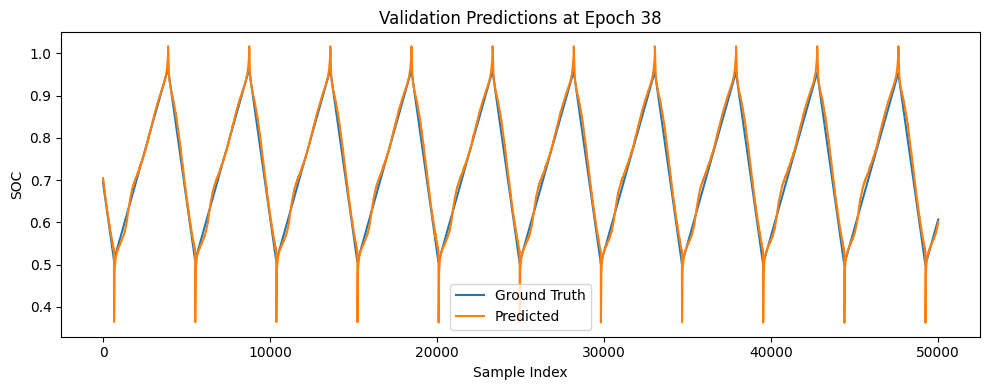

Epoch 039/50, Train MSE: 0.004524, Val MSE: 0.003837, NoImprove: 0


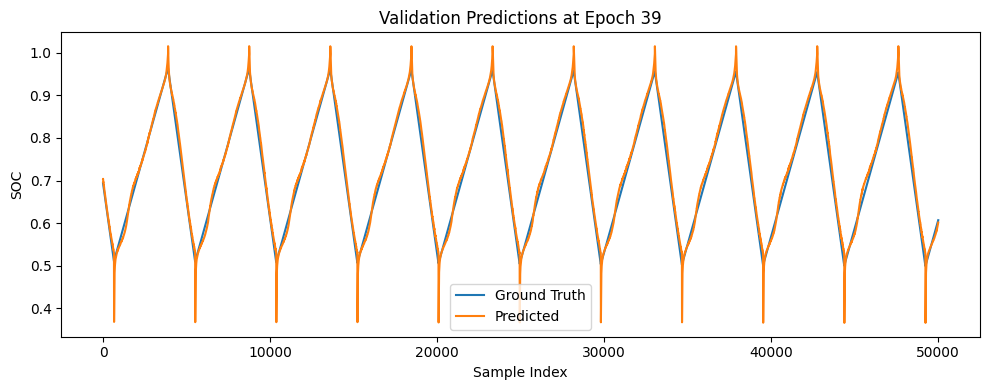

Epoch 040/50, Train MSE: 0.004512, Val MSE: 0.003831, NoImprove: 0


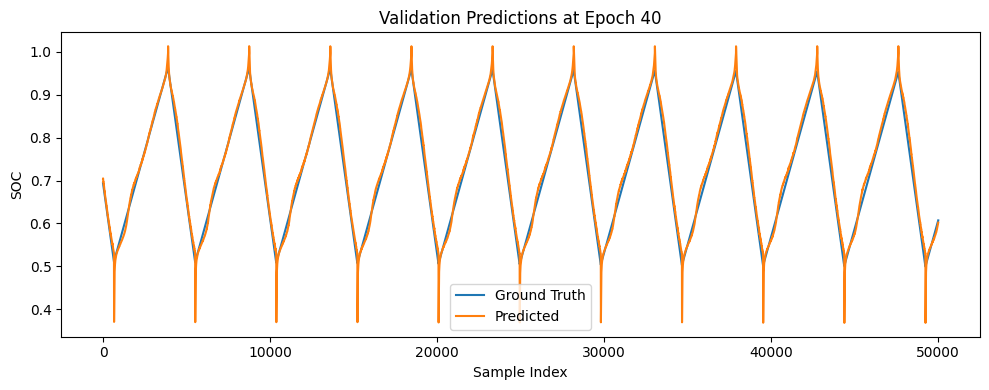

Epoch 041/50, Train MSE: 0.004498, Val MSE: 0.003817, NoImprove: 0


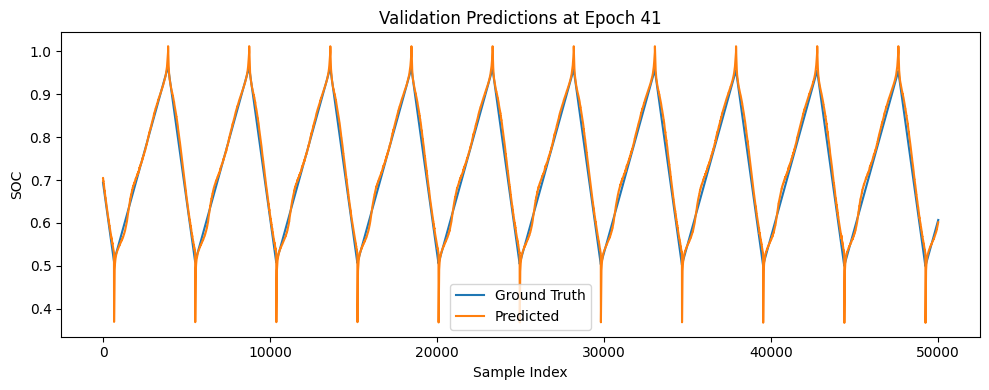

Epoch 042/50, Train MSE: 0.004485, Val MSE: 0.003801, NoImprove: 0


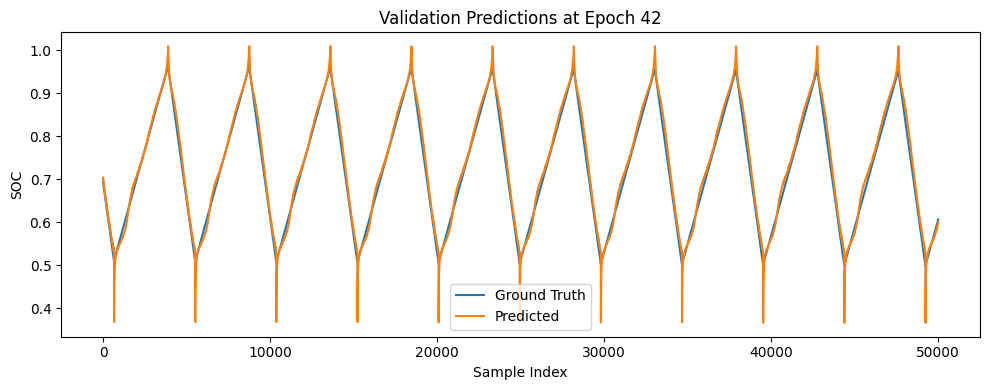

Epoch 043/50, Train MSE: 0.004471, Val MSE: 0.003787, NoImprove: 0


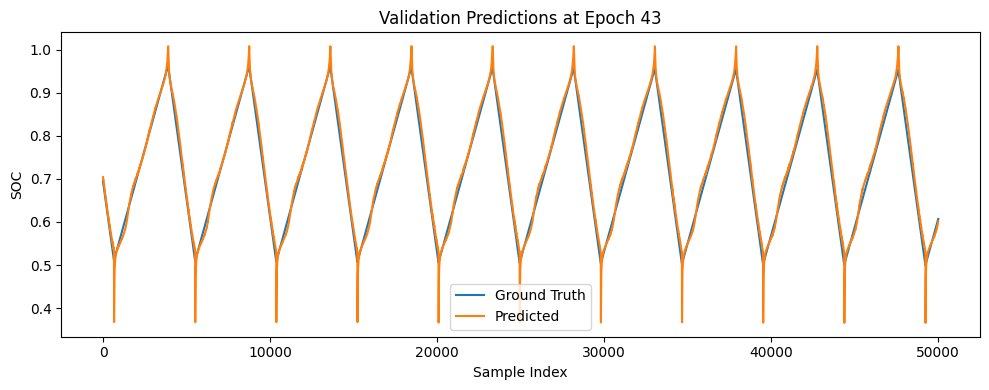

Epoch 044/50, Train MSE: 0.004453, Val MSE: 0.003766, NoImprove: 0


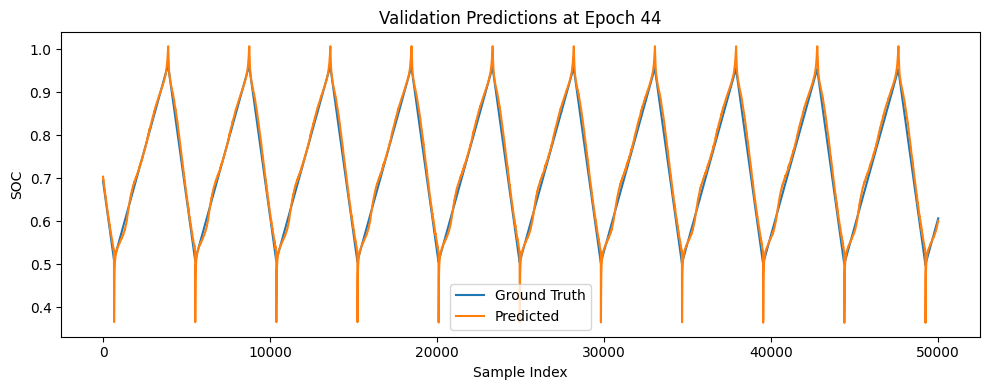

Epoch 045/50, Train MSE: 0.004436, Val MSE: 0.003743, NoImprove: 0


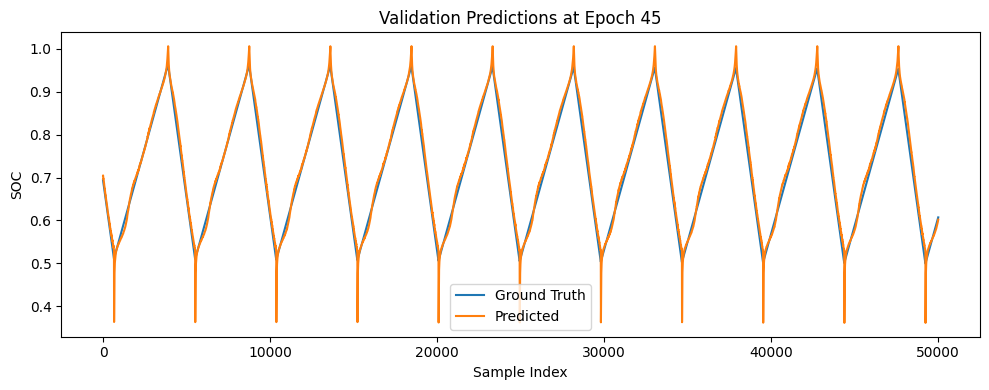

Epoch 046/50, Train MSE: 0.004413, Val MSE: 0.003715, NoImprove: 0


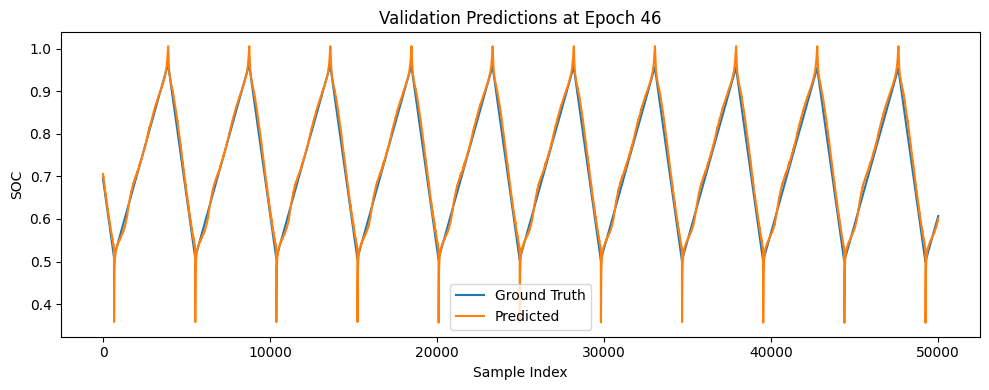

Epoch 047/50, Train MSE: 0.004387, Val MSE: 0.003669, NoImprove: 0


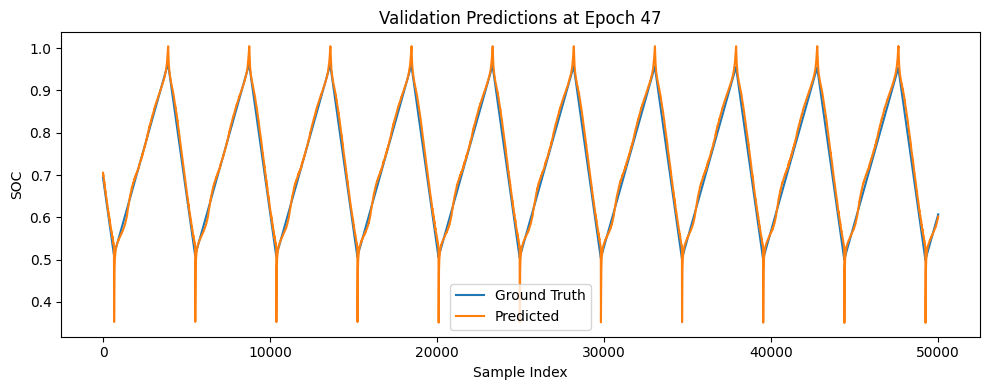

Epoch 048/50, Train MSE: 0.004353, Val MSE: 0.003608, NoImprove: 0


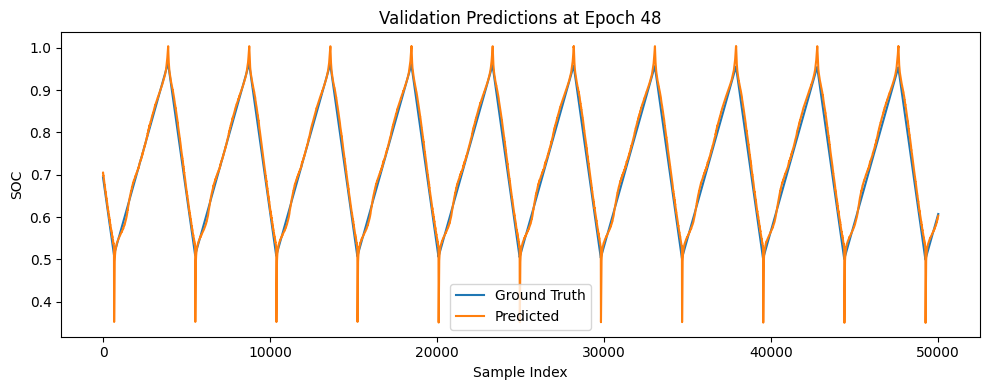

Epoch 049/50, Train MSE: 0.004311, Val MSE: 0.003567, NoImprove: 0


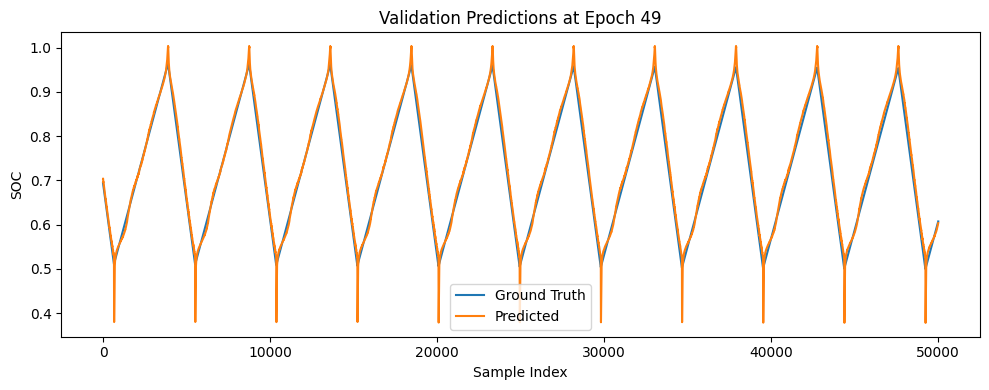

Epoch 050/50, Train MSE: 0.004267, Val MSE: 0.003506, NoImprove: 0


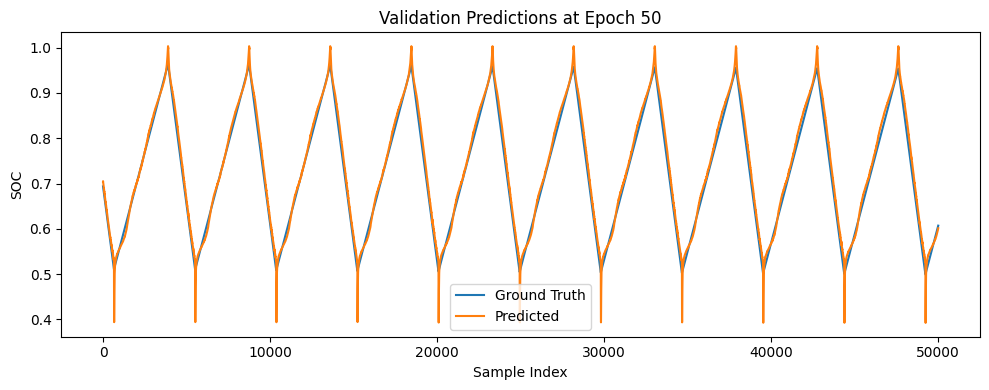


Best model reloaded with val_loss = 0.003506


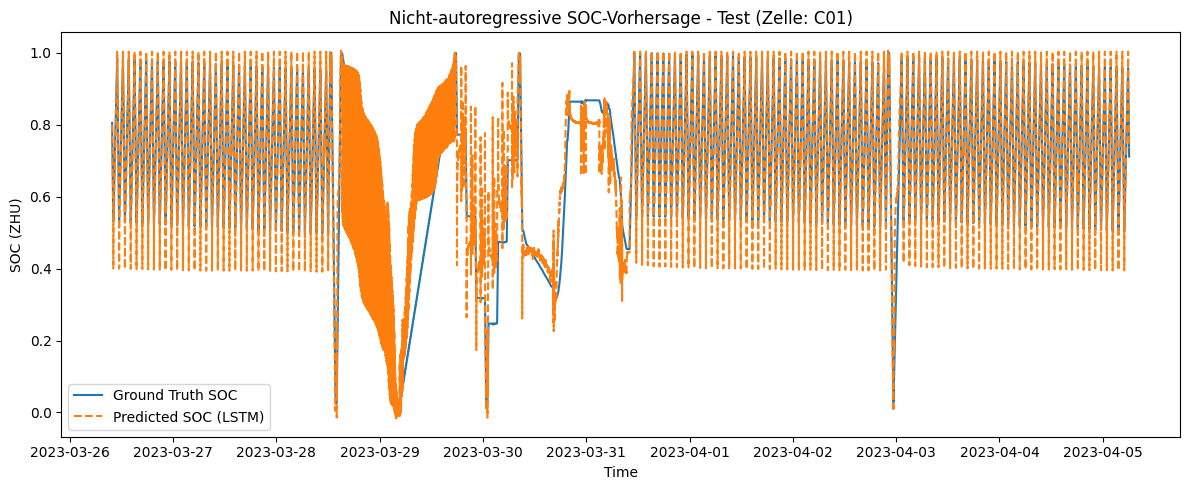

Test-Plot gespeichert unter: models/prediction_test.png
Bestes Modell gespeichert unter: models/best_lstm_soc_model.pth


In [1]:
import os
import sys
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
# Falls du pytorch_forecasting nutzen möchtest:
from pytorch_forecasting.models.nn.rnn import LSTM as ForecastingLSTM

torch.cuda.empty_cache()

###############################################################################
# 1) Laden der Daten, Reduktion auf 25%, zeitbasiertes Split in [Train, Val, Test]
###############################################################################
def load_cell_data(data_dir: Path):
    """Lade df.parquet aus dem Unterordner 'MGFarm_18650_C01'."""
    dataframes = {}
    folder = data_dir / "MGFarm_18650_C01"
    if folder.exists() and folder.is_dir():
        df_path = folder / 'df.parquet'
        if df_path.exists():
            df = pd.read_parquet(df_path)
            dataframes["C01"] = df
            print(f"Loaded {folder.name}")
        else:
            print(f"Warning: No df.parquet found in {folder.name}")
    else:
        print("Warning: Folder MGFarm_18650_C01 not found")
    return dataframes

# Speicherort anpassen:
data_dir = Path('/home/florianr/MG_Farm/5_Data/MGFarm_18650_Dataframes')
cell_data = load_cell_data(data_dir)

# Wir gehen davon aus, dass wir mindestens eine Zelle haben
cell_keys = sorted(cell_data.keys())[:1]
if len(cell_keys) < 1:
    raise ValueError("Keine Zelle gefunden; bitte prüfen.")

cell_name = cell_keys[0]  # z.B. 'C01'
df_full = cell_data[cell_name]

# Reduziere auf 25% der Daten
sample_size = int(len(df_full) * 0.25)
df_small = df_full.head(sample_size).copy()  # vorderer Teil

print(f"Gesamtdaten: {len(df_full)}, wir nehmen 25% = {sample_size} Zeilen.")

# Konvertiere Timestamp für Plot und Analyse
df_small.loc[:, 'timestamp'] = pd.to_datetime(df_small['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])

# Zeitbasiertes Split: Train (40%), Val (40%), Test (20%)
len_small = len(df_small)
train_end = int(len_small * 0.4)
val_end   = int(len_small * 0.8)

df_train = df_small.iloc[:train_end]
df_val   = df_small.iloc[train_end:val_end]
df_test  = df_small.iloc[val_end:]

print(f"Train: {len(df_train)}  |  Val: {len(df_val)}  |  Test: {len(df_test)}")

###############################################################################
# 2) Skalierung von Voltage & Current (SOC bleibt unverändert, da Zielwert)
###############################################################################
scaler = StandardScaler()
features_to_scale = ['Voltage[V]', 'Current[A]']

# Fit nur auf Training
scaler.fit(df_train[features_to_scale])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features_to_scale] = scaler.transform(df_train_scaled[features_to_scale])
df_val_scaled[features_to_scale]   = scaler.transform(df_val_scaled[features_to_scale])
df_test_scaled[features_to_scale]  = scaler.transform(df_test_scaled[features_to_scale])

###############################################################################
# 3) Dataset-Klasse (seq2one, NICHT autoregressiv, KEIN SOC als Input)
###############################################################################
class SequenceDataset(Dataset):
    """
    Für jedes Sample:
      - Input: Fenster aus [Voltage, Current] über seq_len Zeitschritte
      - Label: SOC an (t + seq_len)
    """
    def __init__(self, df, seq_len=60):
        self.seq_len = seq_len
        # Nur Voltage und Current als Features
        self.features = df[["Voltage[V]", "Current[A]"]].values
        # SOC als Zielwert (Label)
        self.labels = df["SOC_ZHU"].values

    def __len__(self):
        return len(self.labels) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.features[idx : idx + self.seq_len]   # shape (seq_len, 2)
        y_val = self.labels[idx + self.seq_len]            # SOC-Wert
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)

# Erstelle Datasets und DataLoader
seq_length = 60
train_dataset = SequenceDataset(df_train_scaled, seq_len=seq_length)
val_dataset   = SequenceDataset(df_val_scaled,   seq_len=seq_length)
test_dataset  = SequenceDataset(df_test_scaled,  seq_len=seq_length)

train_loader = DataLoader(train_dataset, batch_size=50000, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=50000, shuffle=False, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=50000, shuffle=False, drop_last=True)

###############################################################################
# 4) LSTM-Modell (nicht autoregressiv, input_size=2)
###############################################################################
class LSTMSOCModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, num_layers=2, batch_first=True):
        super().__init__()
        self.lstm = ForecastingLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, 2)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Wir nehmen den Output des letzten Zeitschritts
        last_out = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        soc_pred = self.fc(last_out)
        return soc_pred.squeeze(-1)    # (batch_size,)

# Verwende standardmäßigen MSE-Loss
criterion = nn.MSELoss()
model = LSTMSOCModel(input_size=2, hidden_size=32, num_layers=2, batch_first=True)
optimizer = torch.optim.Adam(model.parameters(), lr=50e-3)

###############################################################################
# 5) Training mit Validation, Early Stopping & Gradient Accumulation
###############################################################################
# Plot: Datenaufteilung (Train/Val/Test)
plt.figure(figsize=(12,6))
plt.plot(df_small['timestamp'], df_small['SOC_ZHU'], 'k-', label='SOC (alle Daten)')
plt.axvspan(df_train['timestamp'].iloc[0], df_train['timestamp'].iloc[-1], color='green', alpha=0.3, label='Training')
plt.axvspan(df_val['timestamp'].iloc[0], df_val['timestamp'].iloc[-1], color='orange', alpha=0.3, label='Validation')
plt.axvspan(df_test['timestamp'].iloc[0], df_test['timestamp'].iloc[-1], color='red', alpha=0.3, label='Test')
plt.xlabel('Time')
plt.ylabel('SOC (ZHU)')
plt.title('Datenaufteilung: Train, Val, Test')
plt.legend()
plt.tight_layout()
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 50
patience = 5  # Early Stopping Geduld
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
accumulation_steps = 10

for epoch in range(1, epochs+1):
    model.train()
    train_losses = []
    optimizer.zero_grad()

    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss = loss / accumulation_steps  # Gradient Accumulation
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        train_losses.append(loss.item() * accumulation_steps)

    mean_train_loss = np.mean(train_losses)

    # Validierung
    model.eval()
    val_losses = []
    all_y_val = []
    all_y_pred = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_pred_val = model(x_val)
            v_loss = criterion(y_pred_val, y_val)
            val_losses.append(v_loss.item())
            # Sammle nur den ersten Batch für Plot
            if not all_y_val:
                all_y_val.append(y_val.cpu().numpy())
                all_y_pred.append(y_pred_val.cpu().numpy())
    mean_val_loss = np.mean(val_losses)

    # Early Stopping Check
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} because val_loss not improved.")
            break

    print(f"Epoch {epoch:03d}/{epochs}, Train MSE: {mean_train_loss:.6f}, Val MSE: {mean_val_loss:.6f}, NoImprove: {epochs_no_improve}")

    # Plot Validation Predictions (nur erster Batch)
    y_val_example = all_y_val[0].flatten()
    y_pred_example = all_y_pred[0].flatten()
    plt.figure(figsize=(10,4))
    plt.plot(y_val_example, label='Ground Truth')
    plt.plot(y_pred_example, label='Predicted')
    plt.title(f"Validation Predictions at Epoch {epoch}")
    plt.xlabel("Sample Index")
    plt.ylabel("SOC")
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)
    plt.pause(1)
    plt.close()

# Bestes Modell wiederherstellen
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nBest model reloaded with val_loss = {best_val_loss:.6f}")

###############################################################################
# 6) Nicht-autoregressive Test-Vorhersage auf dem Testset
###############################################################################
model.eval()
test_predictions = []
test_targets = []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        y_pred_test = model(x_test)
        test_predictions.append(y_pred_test.cpu().numpy())
        test_targets.append(y_test.cpu().numpy())

test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Passe die Zeitachse an (da das Dataset um seq_length verschoben ist)
time_test = df_test['timestamp'].values[seq_length:seq_length + len(test_targets)]

plt.figure(figsize=(12,5))
plt.plot(time_test, test_targets, label="Ground Truth SOC", linestyle='-')
plt.plot(time_test, test_predictions, label="Predicted SOC (LSTM)", linestyle='--')
plt.title(f"Nicht-autoregressive SOC-Vorhersage - Test (Zelle: {cell_name})")
plt.xlabel("Time")
plt.ylabel("SOC (ZHU)")
plt.legend()
plt.tight_layout()

# Speichere Plot und Modell (optional)
models_dir = Path(__file__).parent / "models" if "__file__" in globals() else Path("models")
os.makedirs(models_dir, exist_ok=True)

plot_file = models_dir / "prediction_test.png"
plt.savefig(plot_file)
plt.show()
print(f"Test-Plot gespeichert unter: {plot_file}")

model_path = models_dir / "best_lstm_soc_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Bestes Modell gespeichert unter: {model_path}")
